In [25]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer, PowerTransformer
from scipy import stats

In [ ]:
categorical = ['productgroup', 'gender', 'category', 'style', 'sizes']
invariant = ['promo1', 'promo2']
target = ['sales']
numerical = ['regular_price', 'current_price', 'ratio', 'rgb_r_main_col', 'rgb_g_main_col', 'rgb_b_main_col', 'rgb_r_sec_col', 'rgb_g_sec_col', 'rgb_b_sec_col']

In [40]:
Austria = pd.read_parquet("../data/02_intermediate/Austria.pq")
France = pd.read_parquet("../data/02_intermediate/France.pq")
Germany = pd.read_parquet("../data/02_intermediate/Germany.pq")
Countries = {"Austria":Austria,"France":France,"Germany": Germany}

# Check for normality in Sales

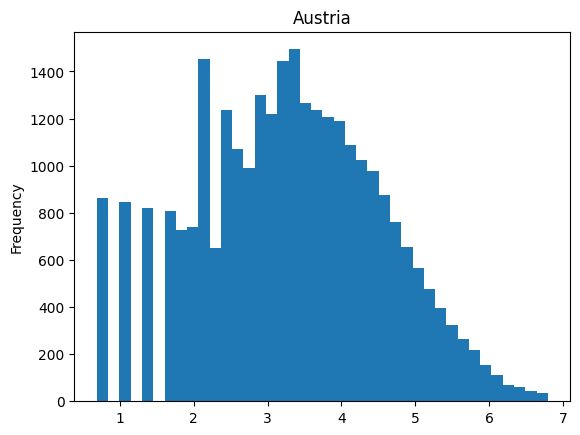

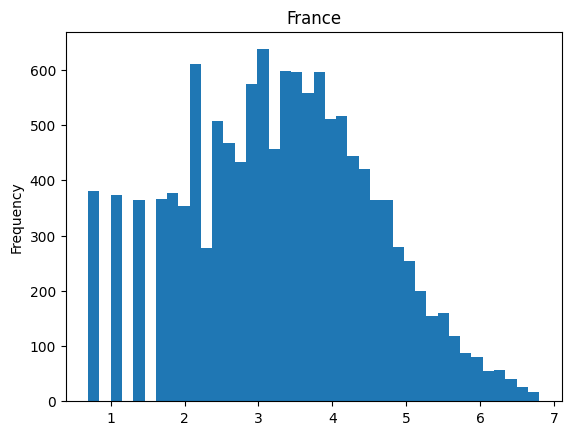

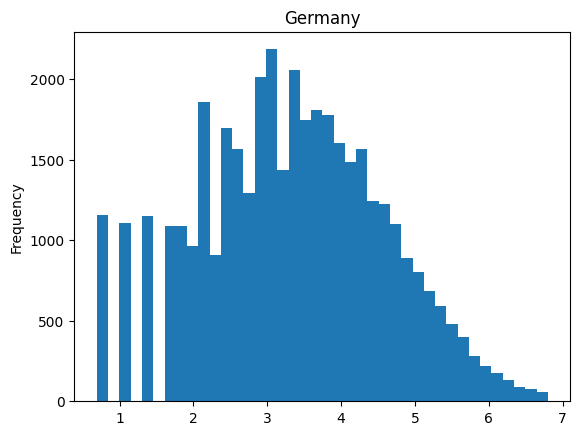

In [42]:
for i in Countries:
    Countries[i].sales.apply(np.log1p).plot.hist(bins=40,title=i)
    plt.show()

In [47]:

def power_transform(df,title): 
    pt = PowerTransformer()

    sales_data = pt.fit_transform(df.sales.values.reshape(-1,1))
    sales_data=np.ravel(sales_data)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
    fig.suptitle(title)
    axes[1,0].hist(sales_data, bins=40, edgecolor='black')
    axes[1,0].set_xlabel("Value")
    axes[1,0].set_ylabel("Frequency")

    axes[1,1].hist(df.sales, bins=40, edgecolor="black")
    axes[1,1].set_xlabel("Value")
    axes[1,1].set_ylabel("Frequency")



    stats.probplot(sales_data, dist='norm', plot=axes[0,0])
    axes[0,0].set_title("Q-Q plot")

    sorted_data = np.sort(sales_data)

    # Calculate the cumulative probabilities for the observed data
    observed_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    # Calculate the cumulative probabilities for the normal distribution
    normal_cdf = stats.norm.cdf(sorted_data, loc=np.mean(sales_data), scale=np.std(sales_data))
    # Plot the P-P plot
    axes[0,1].plot(normal_cdf, observed_cdf, 'o')
    axes[0,1].plot([0, 1], [0, 1], 'k--') # Diagonal line
    axes[0,1].set_xlabel("Theoretical CDF")
    axes[0,1].set_ylabel("Observed CDF")
    axes[0,1].set_title("P-P Plot")
    plt.tight_layout()
    plt.show()
    

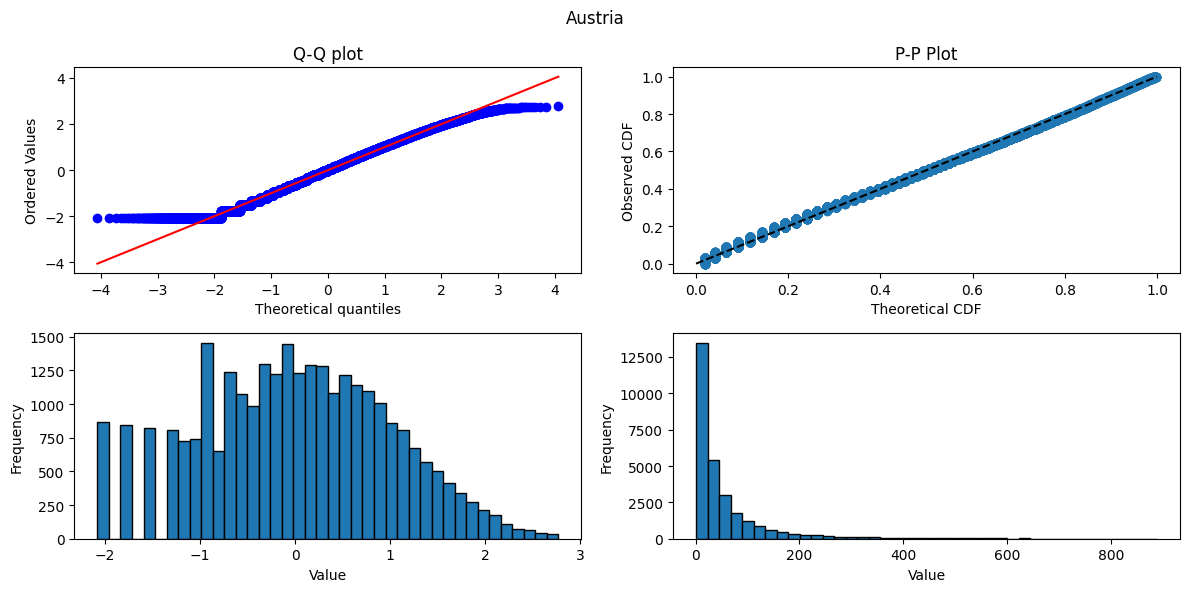

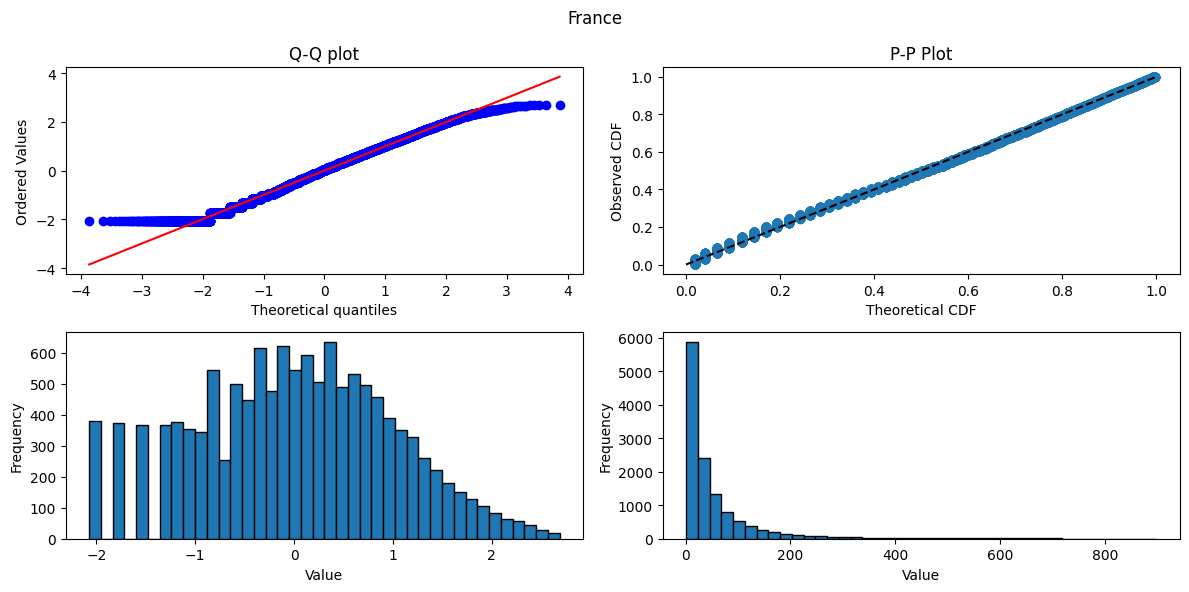

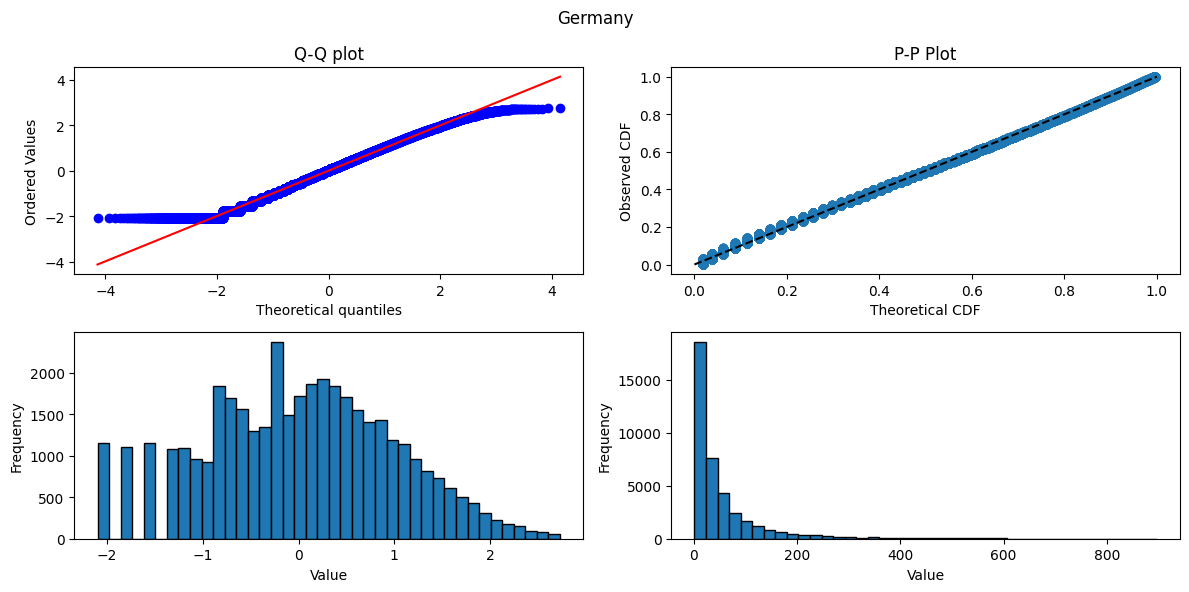

In [48]:
for i in Countries:
    power_transform(Countries[i],i)

Things are not normal but we can keep going on using a regression model for forecast

In [135]:
categorical = ['productgroup', 'gender', 'category', 'style']
bucket=['sizes']
invariant = ['promo1', 'promo2','ratio']
target = ['sales']
numerical = ['regular_price','current_price','main_rgb','sec_rgb']

In [136]:
Austria = pd.read_parquet("../data/02_intermediate/Austria.pq")
France = pd.read_parquet("../data/02_intermediate/France.pq")
Germany = pd.read_parquet("../data/02_intermediate/Germany.pq")
Countries = {"Austria":Austria,"France":France,"Germany": Germany}
for i in Countries:
    Countries[i]["main_rgb"] = 0.3*Countries[i]["rgb_r_main_col"]+ 0.6*Countries[i]["rgb_g_main_col"]+0.11*Countries[i]["rgb_b_main_col"] 
    Countries[i]["sec_rgb"] = 0.3*Countries[i]["rgb_r_sec_col"]+ 0.6*Countries[i]["rgb_g_sec_col"]+0.11*Countries[i]["rgb_b_sec_col"] 
    Countries[i]["retailweek"] = pd.to_datetime(Countries[i]["retailweek"], format="%Y-%m-%d")
    Countries[i]=Countries[i].sort_values(by="retailweek").set_index("retailweek")


In [137]:
for i in Countries:
    print((Countries[i].index < "2017-01-01").sum()/len(Countries[i]))

0.8536585365853658
0.8536585365853658
0.8536585365853658


In [147]:
def bucketize(sizes):
    all_sizes = set(['xxs', 'xs', 's', 'm', 'l', 'xl', 'xxl'])
    sizes_set = set(sizes.split(','))

    if sizes_set == all_sizes:
        return "has it all"
    elif sizes_set & set(['xxs', 'xs', 's']):
        return "has small"
    elif sizes_set & set(['l', 'xl', 'xxl']):
        return "has big"
    else:
        return "other"
def Train_test_split(df:pd.DataFrame):
    #df["size_type"]=df["sizes"].apply(bucketize)
    X,y = df[invariant+categorical+numerical+bucket],df[target]
    # split 80 -20
    new_X, X_test, new_y, y_test = X.loc[X.index < "2017-01-01"], X.loc[X.index > "2017-01-01"],y.loc[y.index < "2017-01-01"], y.loc[y.index > "2017-01-01"] 
    # split 80-20
    X_train, X_val, y_train, y_val = new_X.loc[new_X.index<"2016-08-01"], new_X.loc[new_X.index>"2016-08-01"], new_y.loc[new_y.index<"2016-08-01"], new_y.loc[new_y.index >"2016-08-01"]
    return X_train,X_val,X_test, y_train, y_val, y_test

In [148]:
X_train, X_val, X_test, y_train, y_val, y_test = Train_test_split(Countries[i])

In [156]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomBucketizer(BaseEstimator, TransformerMixin):
    def __init__(self, categories):
        self.categories = categories

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Apply the bucketize function to the input column
        bucketized = X.applymap(bucketize).iloc[:,0]

        # Create a OneHotEncoder with the specified categories
        encoder = OneHotEncoder(categories=[self.categories])

        # Fit and transform the bucketized column
        one_hot_encoded = encoder.fit_transform(bucketized.values.reshape(-1, 1))

        return one_hot_encoded.toarray()

In [157]:
# Define the possible categories for the bucketized variable
bucket_categories = ['has it all', 'has small', 'has big', 'has medium', 'other']

# Define the custom transformer for the bucketized variable
bucket_transformer = CustomBucketizer(categories=bucket_categories)

features_preprocessor = ColumnTransformer(

    transformers= [
        ('numerical', StandardScaler(),numerical),
        ('categorical', OneHotEncoder(handle_unknown="infrequent_if_exist"),categorical),
        ('bucketized', bucket_transformer,bucket),
        ('invariants','passthrough', invariant)
    ])


In [ ]:
from sklearn.ensemble import RandomForestRegressor
regr =TransformedTargetRegressor(regressor=RandomForestRegressor(oob_score=True,criterion='poisson'),transformer=PowerTransformer())
pipe = Pipeline(steps=[('preprocessor', features_preprocessor),('scaled_regression',regr)])
#regr =RandomForestRegressor(oob_score=True,criterion="poisson")
pipe=Pipeline(steps=[("prepare_X",preprocessor_x),("scaled_regression",regr)])
pipe.fit(X_train,y_train)
# print(pipe.score(X_test,y_test),pipe.score(X_train,y_train))
# plt.plot(pipe.predict(X_test),label="prediction")
# plt.plot(y_test,label="real")
# plt.legend()
# plt.show()

In [ ]:
feature_pipeline = Pipeline(steps=[('preprocessor', features_preprocessor)])
processed_features = feature_pipeline.fit_transform(X_train)

In [158]:
processed_features

array([[-0.59290189, -0.09207357, -0.25541198, ...,  1.        ,
         0.        ,  0.81220657],
       [ 0.23648024,  0.28429261, -2.46532399, ...,  1.        ,
         0.        ,  0.57591179],
       [ 1.58806594,  1.5074827 , -1.22100149, ...,  1.        ,
         0.        ,  0.58232152],
       ...,
       [-1.05366975, -0.5625313 , -0.03120083, ...,  1.        ,
         0.        ,  0.94100295],
       [ 0.35935167,  0.9899792 , -1.37627018, ...,  1.        ,
         0.        ,  0.77760127],
       [-0.74649118, -0.18616512, -1.11551361, ...,  1.        ,
         0.        ,  0.88868275]])

In [146]:
X_train.columns

Index(['promo1', 'promo2', 'ratio', 'productgroup', 'gender', 'category',
       'style', 'regular_price', 'current_price', 'main_rgb', 'sec_rgb'],
      dtype='object')

In [125]:
transform = OneHotEncoder(categories=[['has it all', 'has small', 'has big', 'other']])
transform.fit_transform(X_train[categorical]["size_type"].values.reshape(-1,1))


<27300x4 sparse matrix of type '<class 'numpy.float64'>'
	with 27300 stored elements in Compressed Sparse Row format>

In [126]:
transform.categories_

[array(['has it all', 'has small', 'has big', 'other'], dtype=object)]